# VAE

In [1]:
from model import VAE

import tensorflow as tf
import keras as K
import numpy as np
import os

2025-09-29 02:10:44.982366: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-29 02:10:45.003809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759111845.028016   28178 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759111845.034937   28178 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-29 02:10:45.060785: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Data Preprocessing

In [2]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = tf.cast(mnist_digits, tf.float32) / 255.0
mnist_digits = np.expand_dims(mnist_digits, -1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


I0000 00:00:1759111850.272239   28178 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14783 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:03:00.0, compute capability: 7.0


### Training the VAE

In [3]:
vae = VAE(image_size=28, channels=1, latent_dim=2)
vae.compile(optimizer=K.optimizers.Adam())
callbacks = vae.get_callbacks(log_dir="logs", patience=7)
vae.fit(mnist_digits, epochs=30, batch_size=256, callbacks=callbacks)

Epoch 1/30


I0000 00:00:1759111854.776390   28221 service.cc:148] XLA service 0x7decb8014db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759111854.776435   28221 service.cc:156]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2025-09-29 02:10:54.852090: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759111855.268024   28221 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/274 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - kl_loss: 0.0024 - loss: 540.1163 - reconstruction_loss: 540.1139     

I0000 00:00:1759111858.145193   28221 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


274/274 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - kl_loss: 3.7734 - loss: 221.7316 - reconstruction_loss: 217.9582
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - kl_loss: 4.8358 - loss: 169.4774 - reconstruction_loss: 164.6417
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - kl_loss: 5.3971 - loss: 159.1510 - reconstruction_loss: 153.7539
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - kl_loss: 5.6895 - loss: 154.9643 - reconstruction_loss: 149.2748
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - kl_loss: 5.8259 - loss: 152.5816 - reconstruction_loss: 146.7557
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - kl_loss: 5.9517 - loss: 150.8809 - reconstruction_loss: 144.9293
Epoch 7/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - kl_loss: 6.0357 - loss: 149.5659 - reconstruction_loss: 143.5302
Epoch 8/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - kl_loss: 6.1112 - loss: 148.6501 - reconstruction_loss: 142.5389
Epoch 9/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/st

In [4]:
for metric in vae.metrics:
    print(f"{metric.name}: {metric.result().numpy()}")

total_loss: 141.35086059570312
reconstruction_loss: 134.6650390625
kl_loss: 6.685847282409668


Esto da diferente estoy usando un device M3 (a través de Metal Performance Shaders) que en tiene un comportamiento numérico diferente a CUDA. De hecho tuve usar un clip en el kl_loss para evitar explosiones numéricas.

In [5]:
# Save
os.makedirs("./weights", exist_ok=True)
vae.encoder.save("./weights/encoder.keras")
vae.decoder.save("./weights/decoder.keras")

### View Results

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


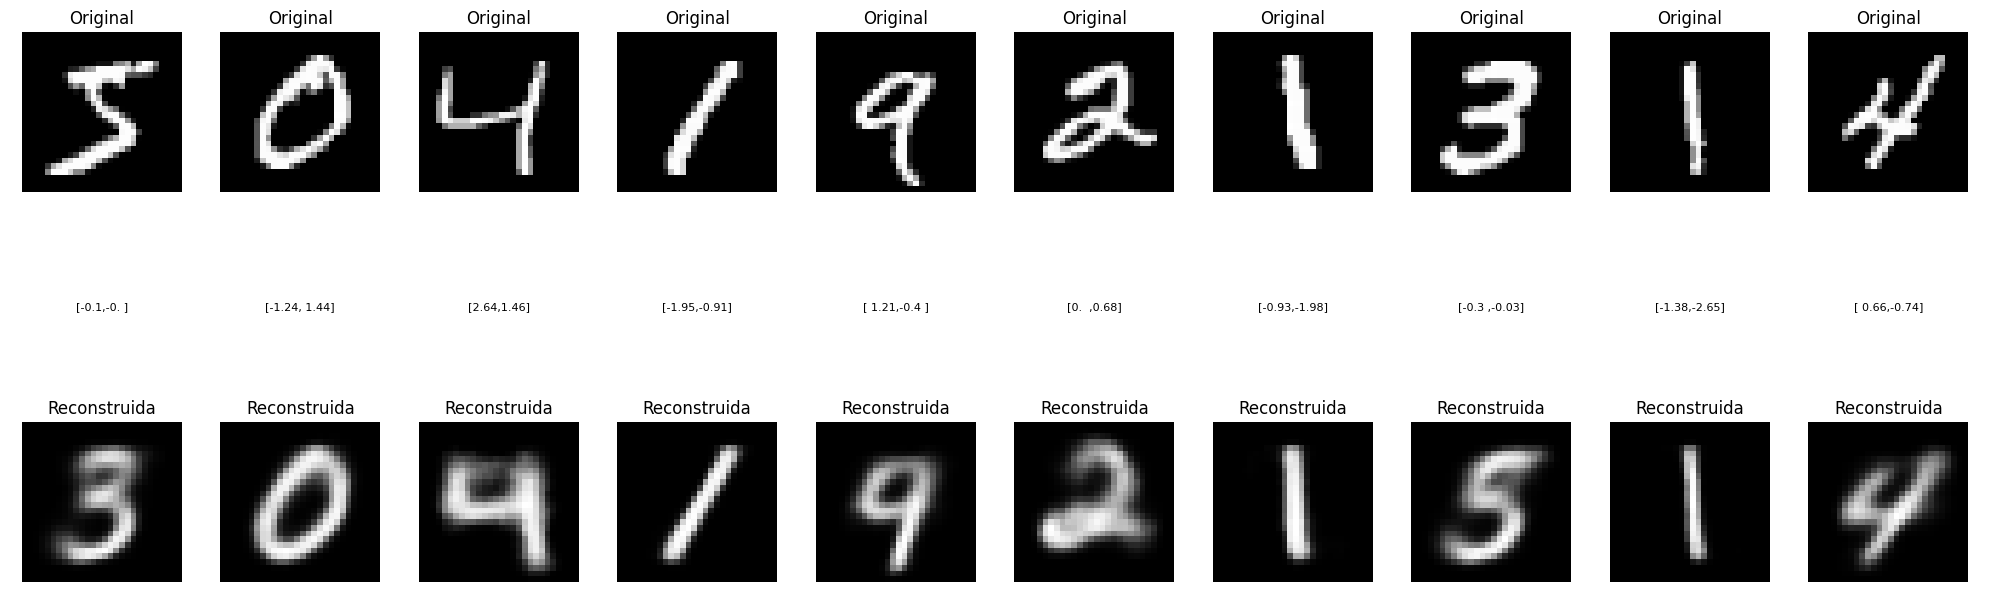

In [6]:
import matplotlib.pyplot as plt

n = 10
example_images = mnist_digits[:n]

# Obtener la representación latente z y las reconstrucciones
z_mean, z_log_var, z = vae.encoder.predict(example_images)
predictions = vae.decoder.predict(z)

plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(example_images[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Vector latente z (como texto en una celda)
    ax = plt.subplot(3, n, i + 1 + n)
    ax.axis("off")
    z_text = np.array2string(z[i], precision=2, separator=",")
    ax.text(0.5, 0.5, z_text, ha="center", va="center", fontsize=8)

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].squeeze(), cmap="gray")
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Fahion MNIST

In [7]:
(x_train, _), (x_test, _) = K.datasets.fashion_mnist.load_data()
fmnist_digits = np.concatenate([x_train, x_test], axis=0)
fmnist_digits = tf.cast(fmnist_digits, tf.float32) / 255.0
fmnist_digits = np.expand_dims(fmnist_digits, -1)

fvae = VAE(image_size=28, channels=1, latent_dim=64)
fvae.compile(optimizer=K.optimizers.Adam())
callbacks = fvae.get_callbacks(log_dir="logs", patience=5)
fvae.fit(fmnist_digits, epochs=30, batch_size=256, callbacks=callbacks)

Epoch 1/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - kl_loss: 9.1786 - loss: 343.7740 - reconstruction_loss: 334.5953
Epoch 2/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - kl_loss: 10.0000 - loss: 280.4965 - reconstruction_loss: 270.4965
Epoch 3/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - kl_loss: 10.0000 - loss: 273.7446 - reconstruction_loss: 263.7446
Epoch 4/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - kl_loss: 10.0000 - loss: 271.0831 - reconstruction_loss: 261.0831
Epoch 5/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - kl_loss: 10.0000 - loss: 269.6952 - reconstruction_loss: 259.6952
Epoch 6/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - kl_loss: 10.0000 - loss: 268.8638 - reconstruction_loss: 258.8639
Epoch 7/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - kl_loss: 10.0000 - loss: 267.9409 - reconstruction_loss: 257.9408
Epoch 8/30
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - kl_loss: 10.0000 - loss: 267.3264 - reconstruction_loss: 257.3264
Epoch 9/30
274/274 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


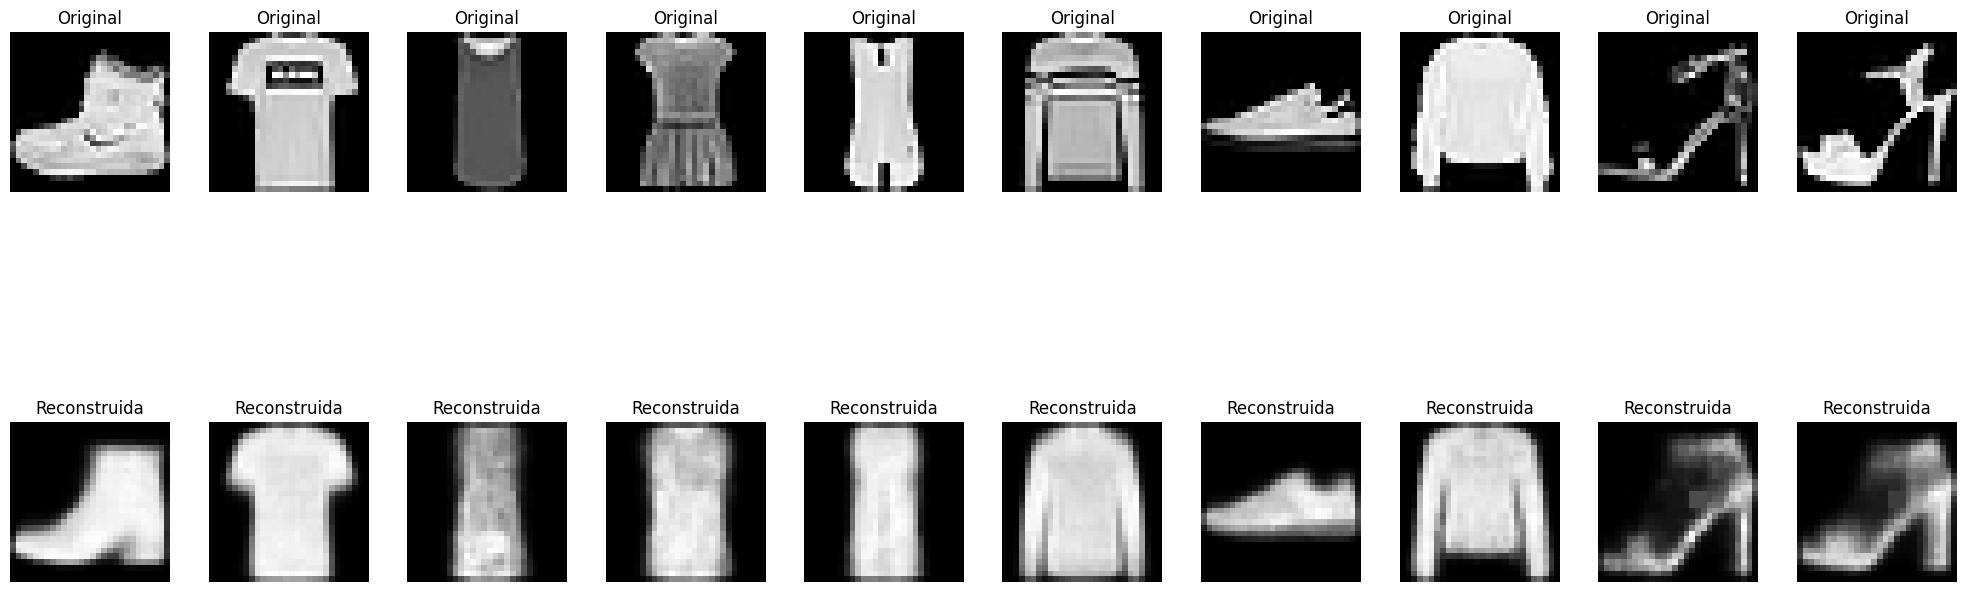

In [8]:
import matplotlib.pyplot as plt

n = 10
example_images = fmnist_digits[:n]

# Obtener la representación latente z y las reconstrucciones
z_mean, z_log_var, z = fvae.encoder.predict(example_images)
predictions = fvae.decoder.predict(z)

plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(example_images[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # Vector latente z (como texto en una celda)
    #ax = plt.subplot(3, n, i + 1 + n)
    #ax.axis("off")
    #z_text = np.array2string(z[i], precision=2, separator=",")
    #ax.text(0.5, 0.5, z_text, ha="center", va="center", fontsize=8)

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].squeeze(), cmap="gray")
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()

## CelebA Dataset

In [9]:
# Import TFDS to download CelebA

import tensorflow_datasets as tfds

# Automatic download
#celeb_a_builder = tfds.builder("celeb_a", version='2.1.0')
#celeb_a_builder.download_and_prepare()

# If downloading manually
celeb_a_builder = tfds.builder("celeb_a", version='2.1.0')
celeb_a_builder.download_and_prepare(download_config=tfds.download.DownloadConfig(manual_dir="../datasets/"))

In [10]:
# Cargar splits de train y test
celeb_a_train = celeb_a_builder.as_dataset(split='train', shuffle_files=True)
celeb_a_test = celeb_a_builder.as_dataset(split='test', shuffle_files=True)

In [11]:
def preprocess_celeba(example):
    image = tf.cast(example['image'], tf.float32) / 255.0
    image = tf.image.resize(image, [64, 64])
    return image

batch_size = 256

celeb_a_train_batched = celeb_a_train.map(preprocess_celeba, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
celeb_a_test_batched = celeb_a_test.map(preprocess_celeba, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [12]:

vae2 = VAE(image_size=64, channels=3, latent_dim=128)

# Debemos reemplazar el decoder para que produzca imágenes de 64x64x3
latent_inputs = K.layers.Input(shape=(vae2.latent_dim,))
x = K.layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = K.layers.Reshape((8, 8, 64))(x)
x = K.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)  # 16x16
x = K.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)  # 32x32
x = K.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)  # 64x64
decoder_outputs = K.layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
custom_decoder = K.Model(latent_inputs, decoder_outputs, name="decoder")

vae2 = VAE(image_size=64, channels=3, latent_dim=128, decoder=custom_decoder)
vae2.compile(optimizer=K.optimizers.Adam())
callbacks2 = vae2.get_callbacks(log_dir="logs", patience=15)
vae2.fit(celeb_a_train_batched, epochs=100, callbacks=callbacks2)

Epoch 1/100


2025-09-29 02:14:20.160721: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


636/636 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - kl_loss: 9.6162 - loss: 2516.6355 - reconstruction_loss: 2507.0198
Epoch 2/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - kl_loss: 10.0000 - loss: 2473.1128 - reconstruction_loss: 2463.1125
Epoch 3/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - kl_loss: 10.0000 - loss: 2472.1848 - reconstruction_loss: 2462.1848
Epoch 4/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - kl_loss: 10.0000 - loss: 2471.5232 - reconstruction_loss: 2461.5232
Epoch 5/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - kl_loss: 10.0000 - loss: 2471.2820 - reconstruction_loss: 2461.2820
Epoch 6/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - kl_loss: 10.0000 - loss: 2471.0513 - reconstruction_loss: 2461.0513
Epoch 7/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - kl_loss: 10.0000 - loss: 2470.8489 - reconstruction_loss: 2460.8489
Epoch 8/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - kl_loss: 10.0000 - loss: 2470.6770 - reconstruction_loss: 2460.6770
Epoch 9/100
6

In [13]:
for metric in vae2.metrics:
    print(f"{metric.name}: {metric.result().numpy()}")

total_loss: 2469.8876953125
reconstruction_loss: 2459.887939453125
kl_loss: 10.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


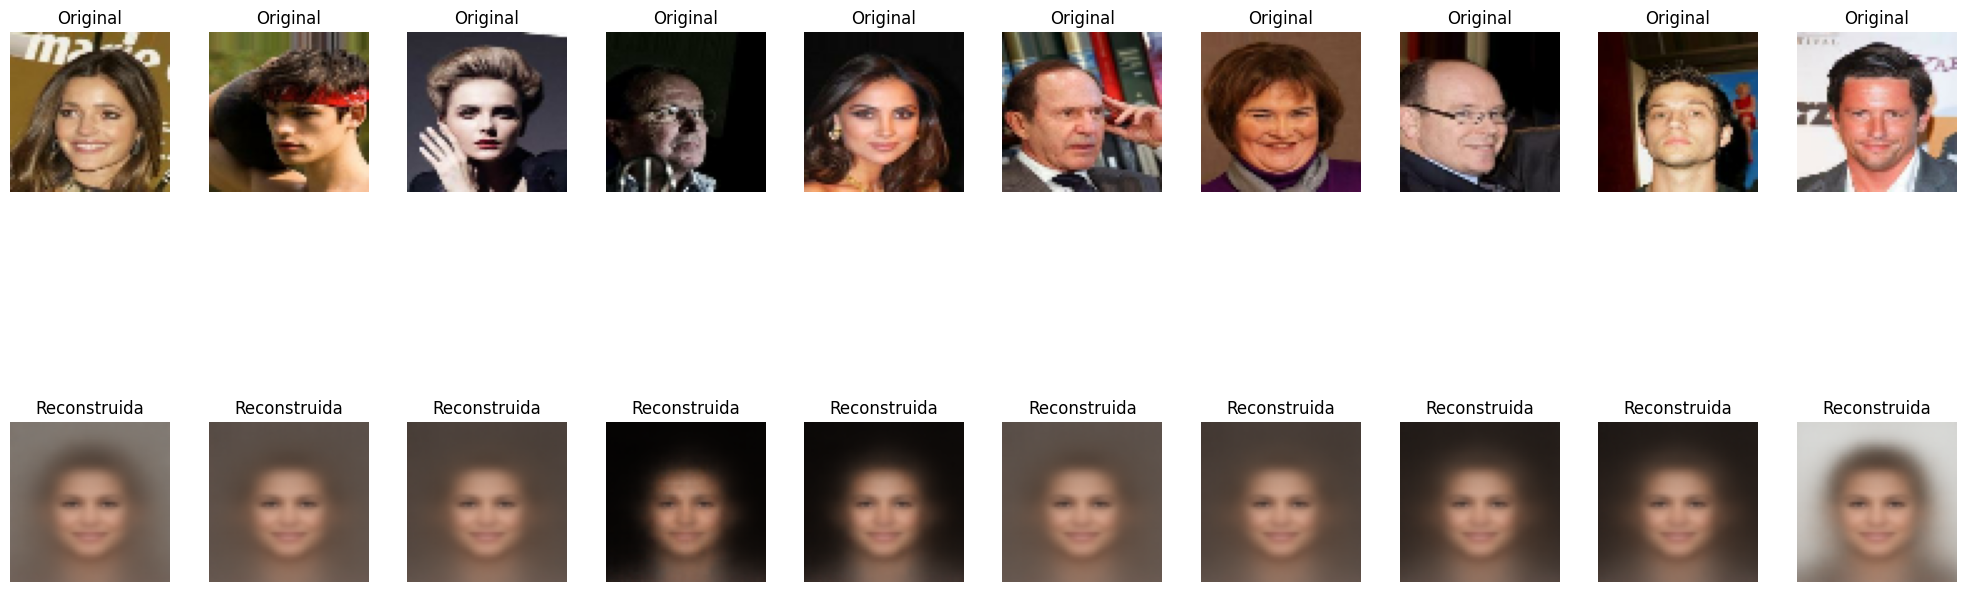

In [14]:
import matplotlib.pyplot as plt

n = 10
images_list = []
for batch in celeb_a_test_batched:
    for img in batch:
        images_list.append(img.numpy())
        if len(images_list) == n:
            break
    if len(images_list) == n:
        break
images = np.stack(images_list)  # shape (n, 64, 64, 3)

# Obtener la representación latente z y las reconstrucciones
z_mean, z_log_var, z = vae2.encoder.predict(images)
predictions = vae2.decoder.predict(z)

plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(images[i].squeeze())
    plt.title("Original")
    plt.axis("off")

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i].squeeze())
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()


# CIFAR-10

In [15]:
(x_train, _), (x_test, _) = K.datasets.cifar10.load_data()
cifar_images = np.concatenate([x_train, x_test], axis=0)
cifar_images = tf.cast(cifar_images, tf.float64) / 255.0

In [16]:
vae3 = VAE(image_size=32, channels=3, latent_dim=256)

# Debemos reemplazar el decoder para que produzca imágenes de 32x32x3
latent_inputs = K.layers.Input(shape=(vae3.latent_dim,))
x = K.layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = K.layers.Reshape((8, 8, 64))(x)
x = K.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)  # 16x16
x = K.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)  # 32x32
x = K.layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(x)  # 32x32
decoder_outputs = K.layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder_outputs = K.layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
custom_decoder = K.Model(latent_inputs, decoder_outputs, name="decoder")

vae3 = VAE(image_size=32, channels=3, latent_dim=256, decoder=custom_decoder)
vae3.compile(optimizer=K.optimizers.Adam(1e-4))
callbacks3 = vae3.get_callbacks(log_dir="logs", patience=20)
vae3.fit(cifar_images, epochs=100, callbacks=callbacks3, batch_size=256)

Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - kl_loss: 0.6799 - loss: 705.6438 - reconstruction_loss: 704.9639
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - kl_loss: 4.7508 - loss: 676.8497 - reconstruction_loss: 672.0991
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - kl_loss: 6.0982 - loss: 666.4464 - reconstruction_loss: 660.3481
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - kl_loss: 7.4426 - loss: 661.6972 - reconstruction_loss: 654.2548
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - kl_loss: 7.9738 - loss: 660.1829 - reconstruction_loss: 652.2092
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - kl_loss: 8.0465 - loss: 659.7096 - reconstruction_loss: 651.6628
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - kl_loss: 8.0992 - loss: 659.5097 - reconstruction_loss: 651.4108
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - kl_loss: 8.1124 - loss: 659.3214 - reconstruction_loss: 651.2089
Epoch 9/100
235/235 ━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


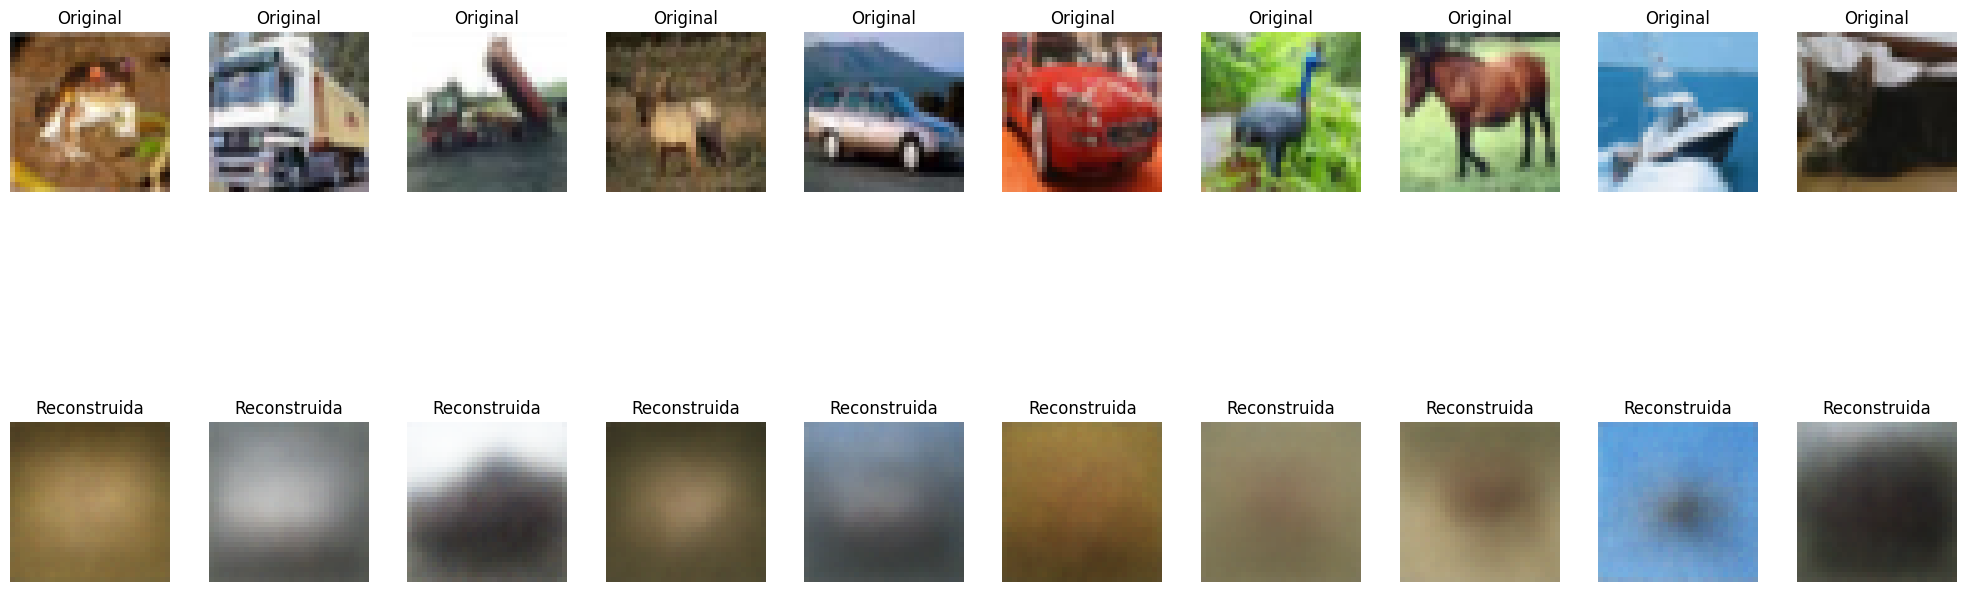

In [17]:
import matplotlib.pyplot as plt

n = 10
images = cifar_images[:n]

# Obtener la representación latente z y las reconstrucciones
z_mean, z_log_var, z = vae3.encoder.predict(images)
predictions = vae3.decoder.predict(z)

plt.figure(figsize=(20, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(images[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predictions[i])
    plt.title("Reconstruida")
    plt.axis("off")

plt.tight_layout()
plt.show()
